# Correlations: How Social Media and the Forex Market Relate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import OrderedDict
import pickle

from matplotlib import style
style.use("ggplot")
pd.options.mode.chained_assignment = None  # default='warn'

Data retrived from [histdata.com](http://www.histdata.com/download-free-forex-historical-data/?/metatrader/1-minute-bar-quotes/usdmxn/2016/10)

In [2]:
# Loading intraday FX: USD v.s. MXN
usd_mxn = pd.read_csv("../secret_files/DAT_MT_USDMXN_M1_201610.csv", 
                      names=["Date","Time","mxn_usd","t2","t3","t4","t5"])

usd_mxn = usd_mxn[["Date", "Time", "mxn_usd"]]

format_time = lambda strtime: strtime.replace(":",".")
to_datetime = lambda input_list: datetime(*[int(x) for x in input_list.split(".")])

# Format Date and time and place it as the index
usd_mxn.index = (usd_mxn["Date"] + "." + usd_mxn["Time"].apply(format_time)).apply(to_datetime)
usd_mxn.drop(["Date", "Time"], axis=1, inplace=True)

In [4]:
usd_mxn.head(5)

,mxn_usd
2016-10-02 17:01:00,19.37168
2016-10-02 17:02:00,19.36975
2016-10-02 17:03:00,19.37475
2016-10-02 17:09:00,19.37475
2016-10-02 17:14:00,19.36730


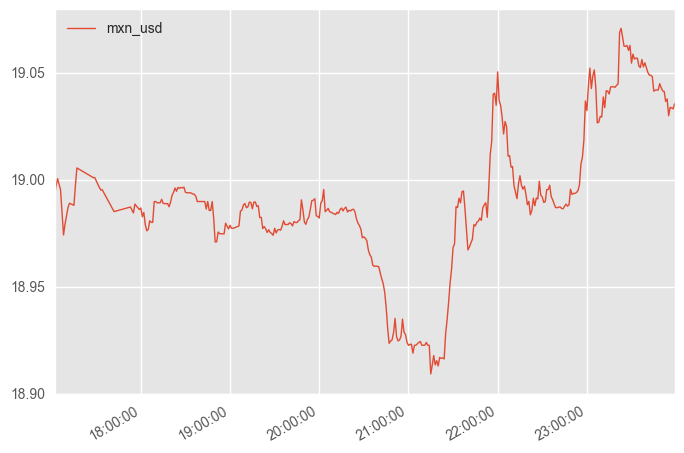

In [5]:
usd_mxn[usd_mxn.index.day == 9].plot(linewidth=1)
plt.show()

In [6]:
# Loading tweets data
with open("../secret_files/debate.pickle", "rb") as f:
    debate_data = pickle.load(f)
len(debate_data)

9999

In [7]:
# First and last retrieved tweet
print(debate_data[0].created_at)
print(debate_data[-1].created_at)

Sun Oct 09 23:59:59 +0000 2016
Sun Oct 09 15:56:03 +0000 2016


In [8]:
debate_df = [tweet.AsDict() for tweet in debate_data]
debate_df = pd.DataFrame(debate_df)

In [9]:
debate_df.head(3)

,coordinates,created_at,favorite_count,geo,hashtags,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,place,possibly_sensitive,retweet_count,retweeted_status,source,text,truncated,urls,user,user_mentions
0,NaN,Sun Oct 09 23:59:59 +0000 2016,NaN,NaN,"[{'text': 'sorrynotsorry'}, {'text': 'debate'}]",785268603868307456,785268603868307456,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Trump giving voice to attacked accusers or usi...,NaN,"[{'url': 'https://t.co/nyARt0OM8L', 'expanded_...","{'profile_link_color': '0084B4', 'url': 'https...",[]
1,NaN,Sun Oct 09 23:59:59 +0000 2016,NaN,NaN,"[{'text': 'Trump'}, {'text': 'Hillary'}]",785268603797049345,785268603797049345,MaddowBlog,NaN,91180720.0,...,NaN,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@MaddowBlog @MSNBC No1 likes as home wrecker n...,NaN,[],"{'profile_link_color': '0084B4', 'name': 'whit...","[{'name': 'Maddow Blog', 'screen_name': 'Maddo..."
2,NaN,Sun Oct 09 23:59:57 +0000 2016,NaN,NaN,[{'text': 'debate'}],785268597656526848,785268597656526848,NaN,NaN,NaN,...,NaN,NaN,1.0,"{'user': {'location': 'NV', 'name': 'Brian F. ...","<a href=""http://twitter.com/download/iphone"" r...",RT @brainfodder: #debate or rape trial from th...,NaN,[],"{'profile_link_color': '0084B4', 'statuses_cou...","[{'name': 'Brian F. Odder', 'screen_name': 'br..."


In [10]:
debate_df.columns

Index(['coordinates', 'created_at', 'favorite_count', 'geo', 'hashtags', 'id',
       'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'lang', 'media', 'place', 'possibly_sensitive',
       'retweet_count', 'retweeted_status', 'source', 'text', 'truncated',
       'urls', 'user', 'user_mentions'],
      dtype='object')

In [11]:
debate_df["text"][:10]

0    Trump giving voice to attacked accusers or usi...
1    @MaddowBlog @MSNBC No1 likes as home wrecker n...
2    RT @brainfodder: #debate or rape trial from th...
3    @PrisonPlanet do you even think trump is good ...
4    RT @Realjmannarino: I don't know if Donald Tru...
5    if i had to choose between hillary or trump i'...
6    RT @VoteTrumpPics: Crooked @HillaryClinton is ...
7    RT @JonLemire: Trump, pre-debate, with women w...
8    RT @VoteTrumpPics: Crooked @HillaryClinton is ...
9    Hillary is the worst human being and Trump ain...
Name: text, dtype: object

In [57]:
# Gathering all words in sample data
def format_tweet(tweet):
    symbols = [".",",","!","?","@", "rt", "#", ";", "\n"]
    tweet = tweet.lower()
    
    # Remove Unecessary symbols
    for symbol in symbols:
        tweet = tweet.replace(symbol, "")
        
    tweet = tweet.split(" ")
    
    return tweet
    
all_words = []
void_words = ["", "the", "or", "is", "of", "as", "this", "2", "you" "have", "a", "to", "if"]
for tweet in debate_df["text"][:10]:
    for word in format_tweet(tweet):
        if word not in void_words:
            all_words.append(word)

In [58]:
pd.value_counts(all_words).sort_values(ascending=False)[:10]

trump                      8
hillary                    5
debate                     4
with                       3
rape                       3
them                       2
consequencesdebates2016    2
merkelvote                 2
all                        2
deal                       2
dtype: int64

In [12]:
debate_df["created_at"][:10]

0    Sun Oct 09 23:59:59 +0000 2016
1    Sun Oct 09 23:59:59 +0000 2016
2    Sun Oct 09 23:59:57 +0000 2016
3    Sun Oct 09 23:59:57 +0000 2016
4    Sun Oct 09 23:59:56 +0000 2016
5    Sun Oct 09 23:59:56 +0000 2016
6    Sun Oct 09 23:59:53 +0000 2016
7    Sun Oct 09 23:59:51 +0000 2016
8    Sun Oct 09 23:59:51 +0000 2016
9    Sun Oct 09 23:59:49 +0000 2016
Name: created_at, dtype: object

In [16]:
def format_twitter_time(date):
    date_list = [2016, 10, 9]
    
    # Split hour, minute and second, put it in a list
    date = date[11:19].split(":")
    
    # Trasform each element from string to int and
    # place it inside 'date_list'
    for element in date:
        date_list.append(int(element))
    
    return datetime(*date_list)

debate_df["created_at"].apply(format_twitter_time)[:10]

0   2016-10-09 23:59:59
1   2016-10-09 23:59:59
2   2016-10-09 23:59:57
3   2016-10-09 23:59:57
4   2016-10-09 23:59:56
5   2016-10-09 23:59:56
6   2016-10-09 23:59:53
7   2016-10-09 23:59:51
8   2016-10-09 23:59:51
9   2016-10-09 23:59:49
Name: created_at, dtype: datetime64[ns]

In [17]:
# Set the date of the creation of the tweet as the index
debate_df.index = debate_df["created_at"].apply(format_twitter_time)
# Sort the index from oldest to latest
debate_df.sort_index(inplace=True)

In [18]:
# Create a new DataFrame with only the texts
ddf = debate_df[["text"]]
# Count instances of Trumps
ddf["Trumps"] = [tweet.lower().count("trump") for tweet in ddf.text.values]
ddf["Debate"] = [tweet.lower().count("debate") for tweet in ddf.text.values]
ddf["Hillary"] = [tweet.lower().count("hillary") for tweet in ddf.text.values]
ddf["Farage"] = [tweet.lower().count("farage") for tweet in ddf.text.values]

In [19]:
ddf.head(5)

,text,Trumps,Debate,Hillary,Farage
created_at,,,,,
2016-10-09 15:56:03,Back to some serious policy issues: Even a wiz...,1,0,0,0
2016-10-09 15:56:05,Focus group: Do you want Hillary or Trump's he...,2,0,1,0
2016-10-09 15:56:07,Help me to win #galaxynote7 and by the way poo...,1,0,0,0
2016-10-09 15:56:09,For Trump it's not whether it's true or not. H...,1,0,1,0
2016-10-09 15:56:10,RT @WayneRoot: Trump's offensive words don't c...,1,0,1,0


In [20]:
# Making a dataframe counting the number of instances 'Trump' was
# said per minute
word_count = ddf.groupby([ddf.index.hour, ddf.index.minute]).sum()

times = []
counts = OrderedDict()
counts["trump_count"] = []
counts["debate_count"] = []
counts["hillary_count"] = []
counts["farage_count"] = []

for time, value in zip(word_count.index, word_count.values):
    hour, minute = time
    times.append(datetime(year=2016, month=10, day=9, hour=hour, minute=minute))
    
    for ix, key in enumerate(counts):
        counts[key].append(value[ix])
    
word_count = pd.DataFrame(counts, index=times)

### Selecting the data where the number of tweets overlap the FX data 

In [21]:
(min(usd_mxn[usd_mxn.index.day == 9].index))

Timestamp('2016-10-09 17:02:00')

In [22]:
min(word_count.index)

Timestamp('2016-10-09 15:56:00')

In [23]:
max(usd_mxn[usd_mxn.index.day == 9].index)

Timestamp('2016-10-09 23:59:00')

In [24]:
max(word_count.index)

Timestamp('2016-10-09 23:59:00')

### Normalize the data

In [25]:
word_count = word_count[word_count.index >= (min(usd_mxn[usd_mxn.index.day == 9].index))]
word_count.head(5)

,trump_count,debate_count,hillary_count,farage_count
2016-10-09 17:02:00,23,0,12,0
2016-10-09 17:03:00,22,4,16,0
2016-10-09 17:04:00,30,2,19,1
2016-10-09 17:05:00,35,2,19,0
2016-10-09 17:06:00,36,16,26,0


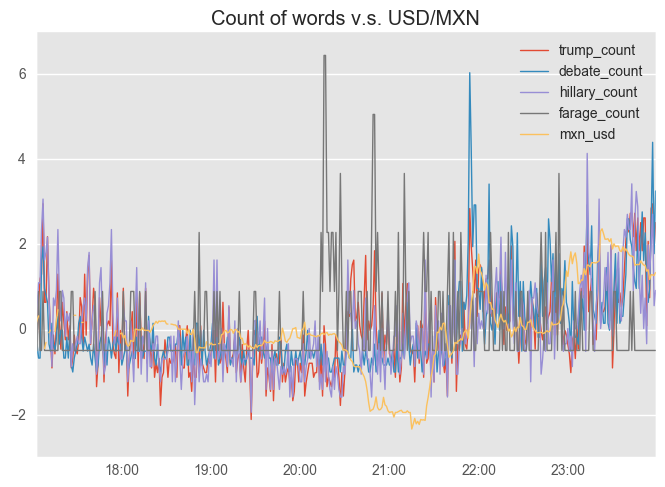

In [26]:
fx_debate = word_count.join(usd_mxn[usd_mxn.index.day == 9])
fx_debate_norm = (fx_debate - fx_debate.mean()) / fx_debate.std()

fx_debate_norm.plot(linewidth=1)
plt.title("Count of words v.s. USD/MXN")
plt.show()

In [27]:
fx_debate.corr()

,trump_count,debate_count,hillary_count,farage_count,mxn_usd
trump_count,1.000000,0.684761,0.799136,0.017922,0.396875
debate_count,0.684761,1.000000,0.535834,-0.062430,0.521047
hillary_count,0.799136,0.535834,1.000000,-0.112940,0.422648
farage_count,0.017922,-0.062430,-0.112940,1.000000,-0.184621
mxn_usd,0.396875,0.521047,0.422648,-0.184621,1.000000


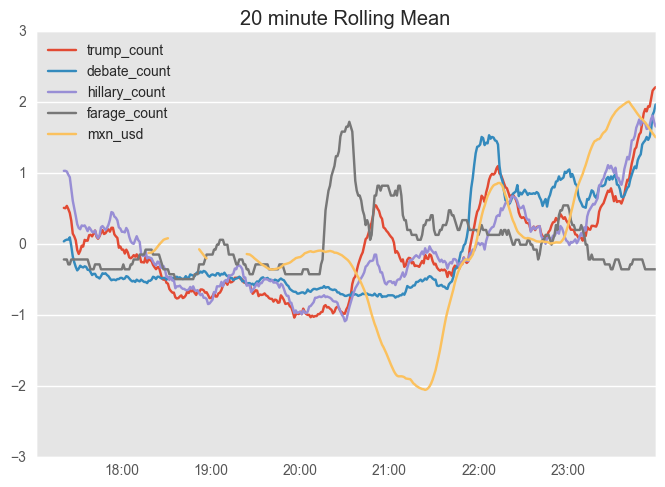

In [28]:
fx_debate_norm.rolling(window=20).mean().plot()
plt.title("20 minute Rolling Mean")
plt.show()

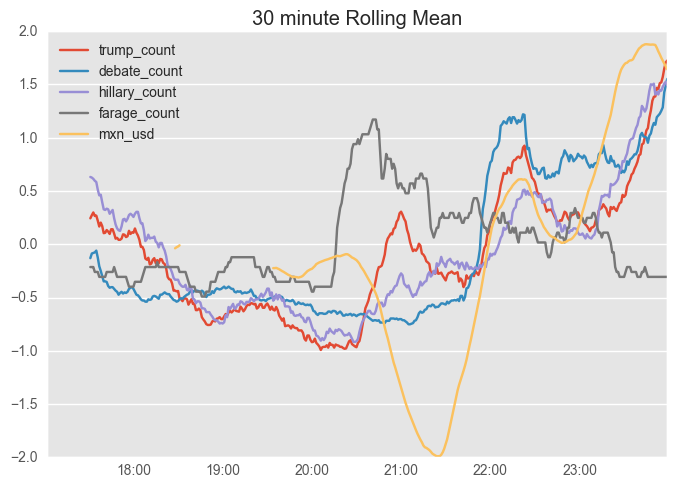

In [29]:
fx_debate_norm.rolling(window=30).mean().plot()
plt.title("30 minute Rolling Mean")
plt.show()

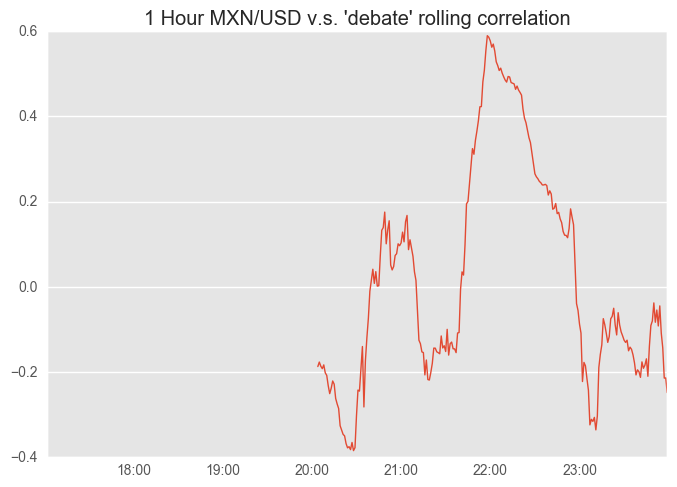

In [30]:
fx_debate.mxn_usd.rolling(window=60).corr(fx_debate.debate_count).plot(linewidth=1)
plt.title("1 Hour MXN/USD v.s. 'debate' rolling correlation")
plt.show()